# Artificial Neural Network

***ABSTRACT***

***In this hands-on practice we build a self-defined Neural Network from scratch by defining the parameters $\Theta$, the sigmoid function, derivative of sigmoid, cross-entropy  function, and performing all the calculations for Forward Propagation and Backpropagtion to train the neural network. We also collect the cost history data during the calculation and finally plot the cost convergence diagram to show how the process is going. We use the Churn_Modelling Dataset for the training of our neural network.***


## 1. Churn_Modelling Dataset

The Churn Modelling dataset contains customers information of a bank with a flag that s/he exits from the bank within 6 months. We will build an ANN to learn from the dataset and predict if a customer will leave the bank or not

### 1.1 Importing the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

datafile = 'https://floobits.com/calvinlow18/ANN/raw/Churn_Modelling.csv'
dataset = pd.read_csv(datafile)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

#y shape looks like (m,), make it looks like (m,1)
y = y[:,np.newaxis]    


### 1.2 Encoding categorical data and Feature Scaling

Encode the country name (string)  and female/male (string) as One Hot Encoding.
Standard scaler other numeric data

Also need One Hot Encoding, see [Label Encoder vs. One Hot Encoder](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621)

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

preprocess = make_column_transformer(
    (OneHotEncoder(),[1,2]),
    (StandardScaler(),[0,3,4,5,6,7,8,9])
    #(MinMaxScaler(feature_range=(0, 1)),[0,3,4,5,6,7,8,9])
)

X = preprocess.fit_transform(X)

m = X.shape[0]
X = np.hstack((np.ones((m,1)), X))

### 1.3 Splitting the dataset into the Training set and Test set


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(8000, 14)
(2000, 14)
(8000, 1)
(2000, 1)


## 2. Build a Neural Network from scratch

![Neural Network Model](https://raw.githubusercontent.com/jchen8000/MachineLearning/master/images/NeuralNetwork.png)

### 2.1 Cross-Entropy Cost Function

> ## $ \min_\Theta J(\Theta)=-\frac{\mathrm{1} }{m} \sum_{i=1}^{m}  \sum_{k=1}^{K}\left[ y_k^{(i)} log((h_\Theta(x^{(i)}))_k) + (1 - y_k^{(i)}) log (1 - (h_\Theta(x^{(i)}))_k) \right]  + \frac{\mathrm{\lambda}}{2m}  \sum_{l=1}^{L-1} \sum_{i=1}^{S_l}\sum_{j=1}^{S_l+1}( \Theta_{ji}^{(l)})^2$

> Where $ h_\Theta(x)  \in  \mathbb{R}^K, (h_\Theta(x))_i = i^{th} output  $

> $ L = $ total no. of layers in neural network

> $ S_l = $ no. of units (not couning bias unit ) in layer $ l $

> ### Think of $ J(\Theta) \approx ( h_\Theta(x^{(i)}) - y^{(i)} ) ^2 $

### 2.2 Sigmoid Function and Derivative of Sigmoid

*  **Sigmoid Function:**
> ## $ g(z) = sigmoid(z) = \frac{\mathrm{1} }{\mathrm{1} + e^{-z} }  $


*  **Derivative of Sigmoid Function:**
> ## $\frac{\mathrm{d} }{\mathrm{d} z}g(z) = g(z)(1-g(z)) $

### 2.3 Backpropagation

> ## $  \delta^{(3)}_j = a_j^{(3)} - y_j $,  ( total number of layers $ L = 3 $ )

> ## $  \delta^{(2)} = ( \Theta^{(2)} )^T  \delta^{(3)} .* g'(z^{(2)}) $

> ## $  \delta^{(1)} = ( \Theta^{(1)} )^T  \delta^{(2)} .* g'(z^{(1)}) $

In [0]:
class Neural_Network(object):
  def __init__(self, inputSize, hiddenSize, outputSize, lmbda):
  #parameters
    self.inputSize = inputSize
    self.outputSize = outputSize
    self.hiddenSize = hiddenSize
    self.lmbda = lmbda
    
  #weights
    epsilon = 0.2
    self.theta1 = np.random.randn(self.inputSize, self.hiddenSize)  * 2 * epsilon - epsilon
    self.theta2 = np.random.randn(self.hiddenSize, self.outputSize) * 2 * epsilon - epsilon
    #self.theta1 = np.random.rand(self.inputSize, self.hiddenSize) * 2 * epsilon - epsilon
    #self.theta2 = np.random.rand(self.hiddenSize, self.outputSize) * 2 * epsilon - epsilon
    
  #history
    self.loss_history =  [] 
    self.cost_history =  [] 
    self.accuracy_history = []

  def forward(self, X):
    #forward propagation through our network
    self.z = np.dot(X, self.theta1) # dot product of X (input) and first set of 3x2 weights
    self.z2 = self.sigmoid(self.z) # activation function
    self.z3 = np.dot(self.z2, self.theta2) # dot product of hidden layer (z2) and second set of 3x1 weights
    o = self.sigmoid(self.z3) # final activation function
    return o

  def sigmoid(self, s):
    # activation function
    return 1/(1+np.exp(-s))

  def sigmoidDerivative(self, s):
    #derivative of sigmoid
    return s * (1 - s)

  def backward(self, X, y, o):
    # backward propagate through the network
    self.o_error = y - o # error in output
    self.o_delta = self.o_error*self.sigmoidDerivative(o) # applying derivative of sigmoid to error

    self.z2_error = self.o_delta.dot(self.theta2.T) # z2 error: how much our hidden layer weights contributed to output error
    self.z2_delta = self.z2_error*self.sigmoidDerivative(self.z2) # applying derivative of sigmoid to z2 error

    self.theta1 += X.T.dot(self.z2_delta) # adjusting first set (input --> hidden) weights
    self.theta2 += self.z2.T.dot(self.o_delta) # adjusting second set (hidden --> output) weights
    
  def cost(self, X, y ):
    m = len(y)
    y_output = self.forward(X)
    
    c1 = np.multiply(y, np.log(y_output))
    c2 = np.multiply(1-y, np.log(1-y_output))
    c = np.sum(c1 + c2)
    
    r1 = np.sum(np.sum(np.power(self.theta1,2), axis = 1))
    r2 = np.sum(np.sum(np.power(self.theta2,2), axis = 1))
    
    #return np.sum(c / (-m)) + ((r1 + r2) * self.lmbda) / (2*m)
    return c / (-m) + ((r1 + r2) * self.lmbda) / (2*m)

  
  def loss(self, X, y):
    return np.mean(np.square(y - self.forward(X)))

  def train(self, X, y, epoch):
    for i in range(epoch):
      o = self.forward(X)
      self.backward(X, y, o)
      acry = accuracy_score(y, (o >= 0.5) )
      cost = self.cost(X,y)
      #self.loss_history.append(self.loss(X,y))
      self.cost_history.append(cost)
      self.accuracy_history.append(acry)
      print("epoch:[", i, "], cost:", str(cost), ";  accuracy:", str(acry)  )

  def predict(self, X):
    return self.forward(X)
  
  
  def get_cost_histroy(self):
    return self.cost_history
  
  def get_loss_histroy(self):
    return self.loss_history

  def get_accuracy_histroy(self):
    return self.accuracy_history  
  
  def get_weight(self):
    return self.theta1, self.theta2


In [0]:
def plotCost(cost_history, iterations):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(cost_history)),cost_history,'bo')
    plt.grid(True)
    plt.title("Cost by Iterations")
    plt.xlabel("Iteration number")
    plt.ylabel("Cost function")
    dummy = plt.xlim([-0.05*iterations,1.05*iterations])
    dummy = plt.ylim([min(cost_history)-0.2*(max(cost_history)-min(cost_history)), max(cost_history)+0.2*(max(cost_history)-min(cost_history))])

    
def plotAccuracy(accuracy_history, iterations):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(accuracy_history)),accuracy_history,'bo')
    plt.grid(True)
    plt.title("Accuracy by Iterations")
    plt.xlabel("Iteration number")
    plt.ylabel("Accuracy Score")
    dummy = plt.xlim([-0.05*iterations,1.05*iterations])
    dummy = plt.ylim([min(accuracy_history)-0.2*(max(accuracy_history)-min(accuracy_history)), max(accuracy_history)+0.2*(max(accuracy_history)-min(accuracy_history))])
  
  
    

In [0]:
NN = Neural_Network( inputSize=14, 
                     hiddenSize=3, 
                     outputSize=1, 
                     lmbda=1 )


iterations = 500
NN.train(X_train, y_train, iterations)


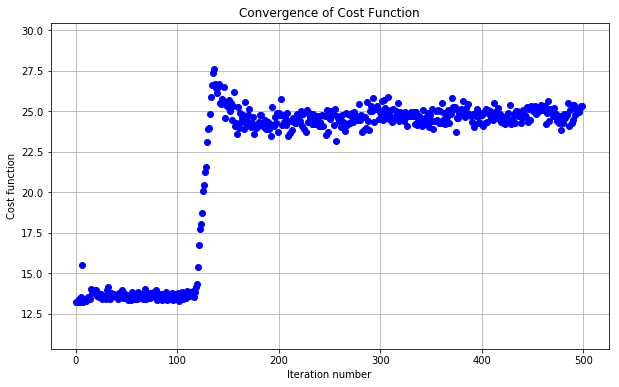

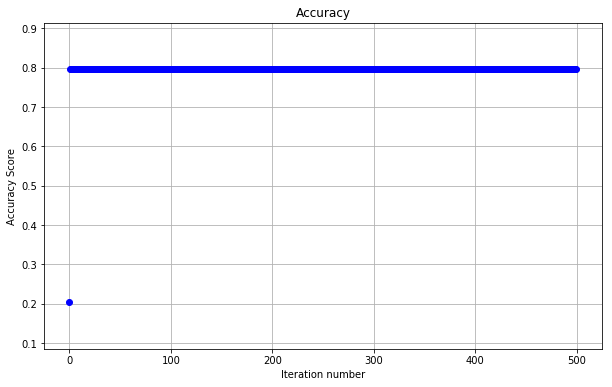

In [12]:
plotCost(NN.get_cost_histroy(), iterations )
plotAccuracy(NN.get_accuracy_histroy(), iterations )

In [0]:
y_pred = NN.predict(X_test)
y_pred = (y_pred >= 0.5)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))